In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import time
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from functools import partial
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
import tensorflow_datasets as tfds

assert tf.__version__ >= "2.0"

In [18]:
# 8.22 결과를 그래프로 나타내기 
def show_plot(history, save_name = None):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, "bo", label = "Training accuracy")
  plt.plot(epochs, val_acc, "b", label = "Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  if save_name == None: pass
  else: plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/accuracy_{save_name}.png')
  plt.figure()
  
  plt.plot(epochs, loss , "bo", label = "Training loss")
  plt.plot(epochs, val_loss, "b", label = "Validation_loss")
  plt.title("Training and validation loss")
  plt.legend()
  if save_name == None: pass
  else: plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/loss_{save_name}.png')
  plt.show()

In [19]:
# 8.26 테스트 세트에서 모델 평가하기
def model_test(MODEL_PATH, test_set):
  test_model = keras.models.load_model(MODEL_PATH)
  test_loss, test_acc = test_model.evaluate(test_set)
  print(f"테스트 정확도 : {test_acc*100:.3f}%")
  return test_loss, test_acc

# 1. Rock_paper_scissors

#### train / validation / test set 분리

In [20]:
dataset, info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)
class_names = info.features["label"].names # ["rock", "paper", "scissors"]
n_classes = info.features["label"].num_classes # 3
dataset_size = info.splits["train"].num_examples # 2520

test_set_raw, valid_set_raw, train_set_raw = tfds.load("rock_paper_scissors", 
                                                       as_supervised=True, 
                                                       split=["train[:10%]","train[10%:25%]", "train[25%:]"])


def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label


batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

rsp_results = pd.DataFrame(columns = ['test_acc', 'test_loss', 'pred_time'], index = ['Xception_without_data_augmentation', 'Xception_with_data_augmentation', 'Xception_change_hp'])

```label names``` = ['rock', 'paper', 'scissors']  
```num_classes``` = 3   
```
FeaturesDict({
    'image': Image(shape=(300, 300, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
```

```
info.splits
>>> {Split('train'): <SplitInfo num_examples=2520, num_shards=2>,
 Split('test'): <SplitInfo num_examples=372, num_shards=1>}
 ```


- **데이터 확인**

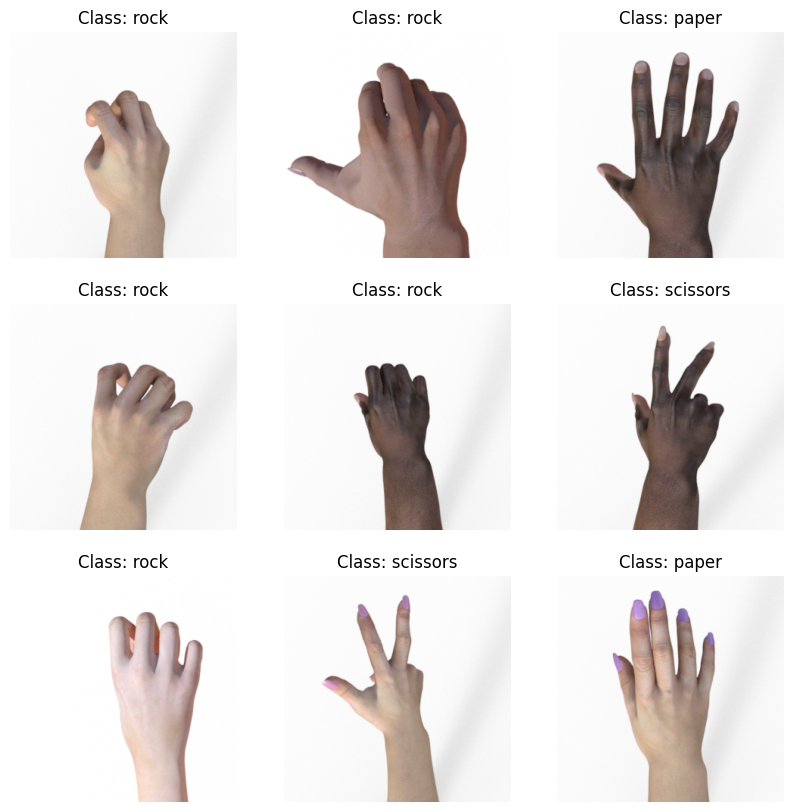

In [21]:
plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## (1) Data augmentation 미적용

Epoch 1/40
59/59 [==============================] - 23s 107ms/step - loss: 0.1885 - accuracy: 0.9364 - val_loss: 0.6879 - val_accuracy: 0.7131
Epoch 2/40
59/59 [==============================] - 5s 88ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.3057 - val_accuracy: 0.8892
Epoch 3/40
59/59 [==============================] - 5s 88ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 4/40
59/59 [==============================] - 5s 88ms/step - loss: 9.6900e-04 - accuracy: 1.0000 - val_loss: 4.6036e-04 - val_accuracy: 1.0000
Epoch 5/40
59/59 [==============================] - 6s 96ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 3.4785e-04 - val_accuracy: 1.0000
Epoch 6/40
59/59 [==============================] - 5s 88ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.5653e-04 - val_accuracy: 1.0000
Epoch 7/40
59/59 [==============================] - 5s 91ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.4263e-04 - val_accuracy

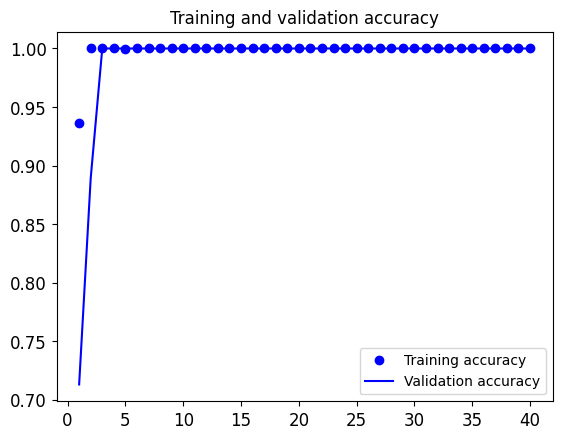

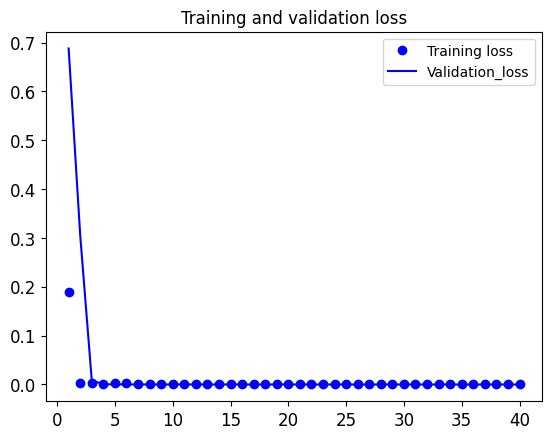

8/8 [==============================] - 1s 45ms/step - loss: 1.8010e-05 - accuracy: 1.0000
테스트 정확도 : 100.000%
8/8 [==============================] - 1s 14ms/step


In [22]:
base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

MODEL_SAVE_PATH = "/content/drive/My Drive/딥러닝/TermProject/rsp_Xception_without_data_augmentation.keras"
EPOCHS = 40 

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

model1_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model1_history, "rsp_without_data_augmentation") # history graph
model1_test_loss, model1_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model1_predict_time = end - start # prediction_time

rsp_results.loc["Xception_without_data_augmentation"] = (model1_test_acc, model1_test_loss, model1_predict_time) 

## (2) Data augmentation 적용

In [23]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


# 데이터 증강을 포함한 전처리 함수 정의
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential( # data augmentation
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- **augmentation 결과 확인**

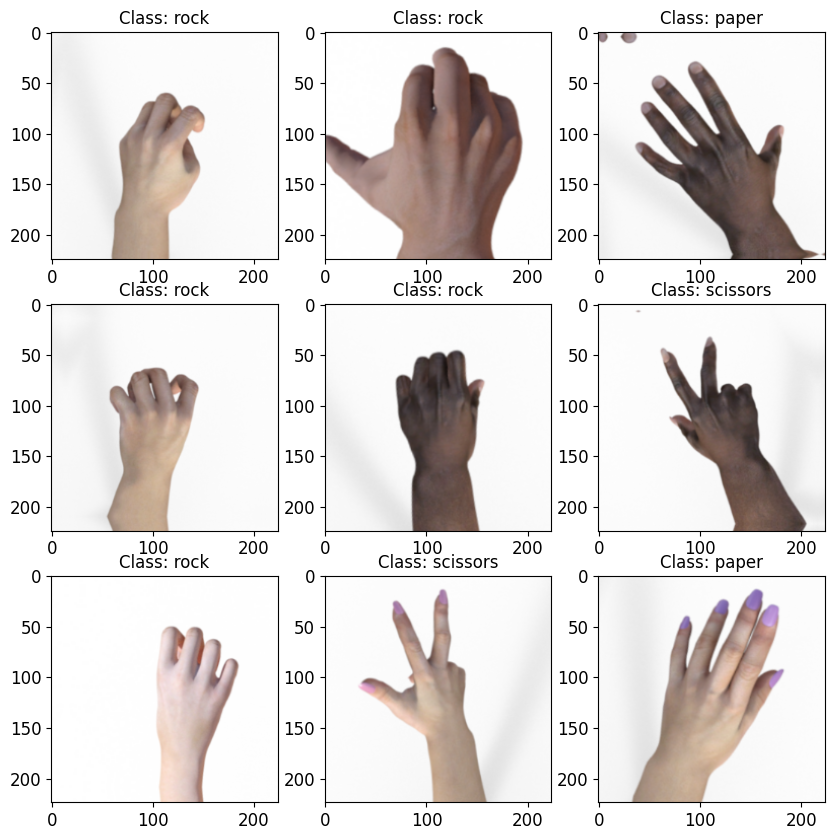

In [24]:
# augmentation 결과 확인 
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(augment_preprocess)).batch(batch_size).prefetch(1)
train_set = train_set_raw.map(augment_preprocess)

plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))

plt.show()

Epoch 1/40
59/59 [==============================] - 23s 108ms/step - loss: 0.2288 - accuracy: 0.9047 - val_loss: 0.3330 - val_accuracy: 0.8523
Epoch 2/40
59/59 [==============================] - 5s 92ms/step - loss: 0.0222 - accuracy: 0.9931 - val_loss: 0.2712 - val_accuracy: 0.9205
Epoch 3/40
59/59 [==============================] - 5s 91ms/step - loss: 0.0123 - accuracy: 0.9952 - val_loss: 0.2584 - val_accuracy: 0.9205
Epoch 4/40
59/59 [==============================] - 5s 92ms/step - loss: 0.0152 - accuracy: 0.9958 - val_loss: 0.0795 - val_accuracy: 0.9574
Epoch 5/40
59/59 [==============================] - 5s 92ms/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.0241 - val_accuracy: 0.9915
Epoch 6/40
59/59 [==============================] - 5s 91ms/step - loss: 0.0068 - accuracy: 0.9974 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 7/40
59/59 [==============================] - 5s 77ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0075 - val_accuracy: 0.9972
Epoch 8/40


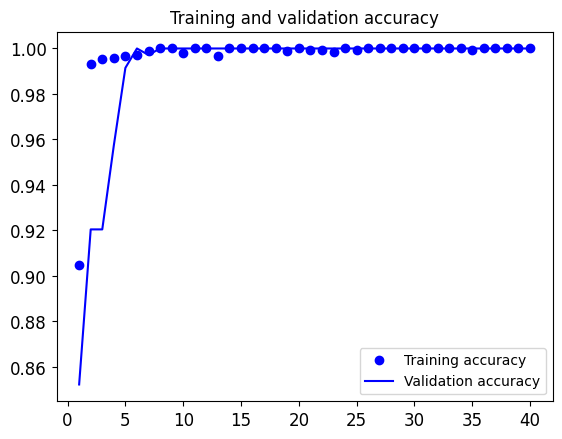

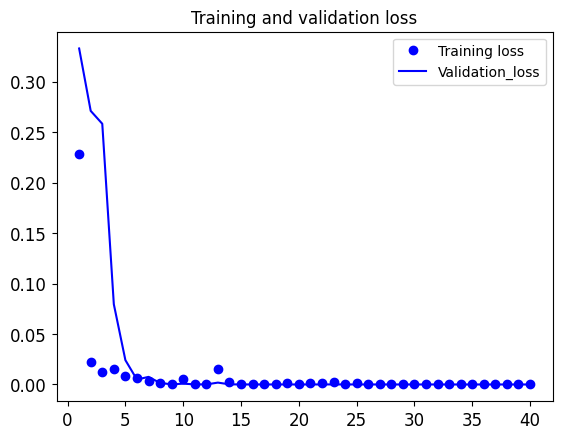

8/8 [==============================] - 1s 19ms/step - loss: 1.2124e-06 - accuracy: 1.0000
테스트 정확도 : 100.000%
8/8 [==============================] - 1s 16ms/step


In [25]:
# 모델 적용을 위해 Input_size 수정한 ver
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    resized_image = tf.squeeze(resized_image)  # 차원 축소
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 데이터 증강을 포함한 전처리 함수 정의 (모델 적용을 위해 Input_size 수정한 ver)
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential(
    [
        layers.Conv2D(3, 3, input_shape=(224, 224, 3)),  # 입력 형태 설정
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

# inputs = keras.Input(shape=(None, None, 3)) 
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  


model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "/content/drive/My Drive/딥러닝/TermProject/rsp_Xception_with_data_augmentation.keras"
EPOCHS = 40

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model2_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model2_history, "rsp_with_data_augmentation") # history graph
model2_test_loss, model2_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model2_predict_time = end - start # prediction_time

rsp_results.loc["Xception_with_data_augmentation"] = (model2_test_acc, model2_test_loss, model2_predict_time) 

## (3) 1-(2)에서 hyper parameter 변형

- 기존
  - epochs = 40
  - learning_rate = 0.01
  - batch_size = 32

#### 1. learning rate 영향

Epoch 1/40
59/59 [==============================] - 9s 83ms/step - loss: 0.0238 - accuracy: 0.9899 - val_loss: 3.6237e-08 - val_accuracy: 1.0000
Epoch 2/40
59/59 [==============================] - 4s 62ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 1.6797e-07 - val_accuracy: 1.0000
Epoch 3/40
59/59 [==============================] - 4s 62ms/step - loss: 0.0229 - accuracy: 0.9963 - val_loss: 0.0139 - val_accuracy: 0.9972
Epoch 4/40
59/59 [==============================] - 4s 68ms/step - loss: 0.0364 - accuracy: 0.9915 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/40
59/59 [==============================] - 4s 63ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/40
59/59 [==============================] - 4s 64ms/step - loss: 3.9760 - accuracy: 0.8014 - val_loss: 41.3176 - val_accuracy: 0.4432
Epoch 7/40
59/59 [==============================] - 4s 65ms/step - loss: 1.2607 - accuracy: 0.5519 - val_loss: 3.0897 - val_accuracy: 0.6

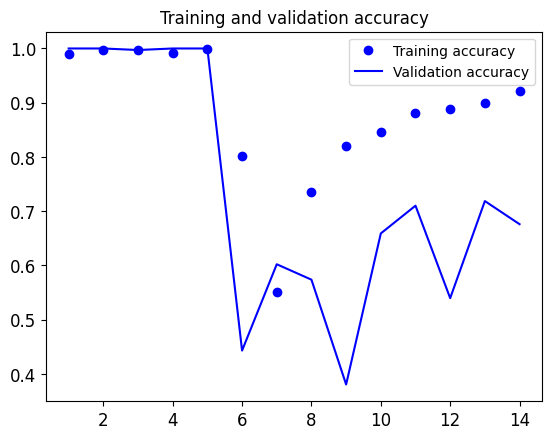

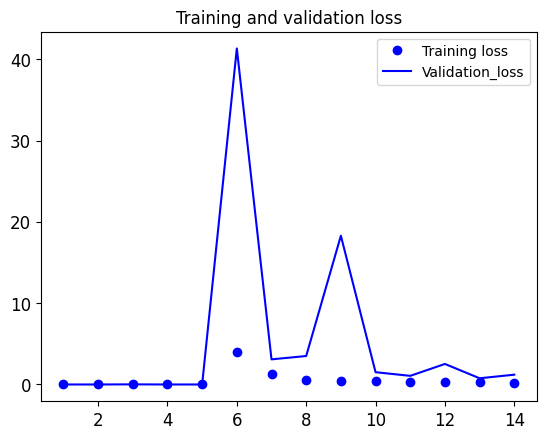

8/8 [==============================] - 1s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
테스트 정확도 : 100.000%


In [26]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 0.1

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
 
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_change_hyperparameters.keras"

callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/40
59/59 [==============================] - 9s 83ms/step - loss: 1.1124 - accuracy: 0.2532 - val_loss: 1.1172 - val_accuracy: 0.3011
Epoch 2/40
59/59 [==============================] - 4s 68ms/step - loss: 1.1116 - accuracy: 0.2648 - val_loss: 1.1125 - val_accuracy: 0.2188
Epoch 3/40
59/59 [==============================] - 4s 69ms/step - loss: 1.1087 - accuracy: 0.2834 - val_loss: 1.1102 - val_accuracy: 0.2472
Epoch 4/40
59/59 [==============================] - 4s 69ms/step - loss: 1.1089 - accuracy: 0.2839 - val_loss: 1.1086 - val_accuracy: 0.2670
Epoch 5/40
59/59 [==============================] - 4s 71ms/step - loss: 1.1054 - accuracy: 0.2908 - val_loss: 1.1071 - val_accuracy: 0.2955
Epoch 6/40
59/59 [==============================] - 4s 72ms/step - loss: 1.1058 - accuracy: 0.2865 - val_loss: 1.1058 - val_accuracy: 0.3210
Epoch 7/40
59/59 [==============================] - 4s 69ms/step - loss: 1.1048 - accuracy: 0.2940 - val_loss: 1.1045 - val_accuracy: 0.3438
Epoch 8/40
59

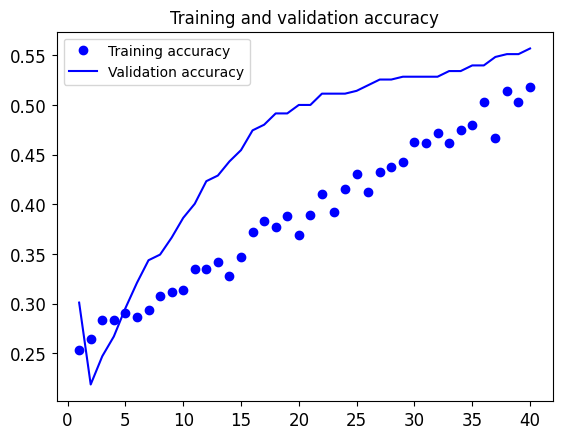

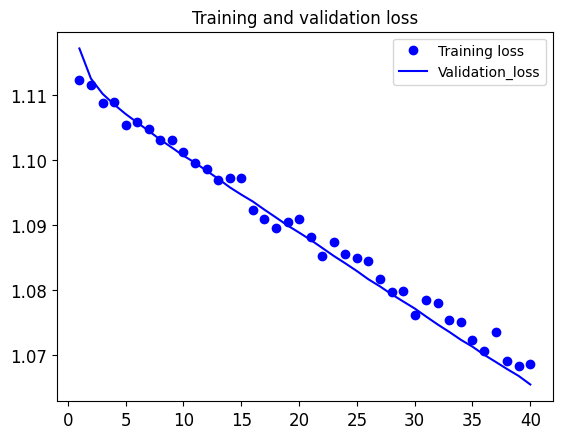

8/8 [==============================] - 1s 19ms/step - loss: 1.0614 - accuracy: 0.5873
테스트 정확도 : 58.730%


In [27]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 1e-5

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
 
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_change_hyperparameters.keras"

callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

#### 2. epochs 영향 (이미 lr = 0.1일 때 test accuracy가 1.0이므로 비교할 필요가 없다고 판단)

Epoch 1/40
59/59 [==============================] - 10s 85ms/step - loss: 0.3699 - accuracy: 0.8538 - val_loss: 1.6396 - val_accuracy: 0.6619
Epoch 2/40
59/59 [==============================] - 4s 62ms/step - loss: 0.2166 - accuracy: 0.9248 - val_loss: 1.7996 - val_accuracy: 0.6222
Epoch 3/40
59/59 [==============================] - 4s 70ms/step - loss: 0.1820 - accuracy: 0.9349 - val_loss: 1.1803 - val_accuracy: 0.6108
Epoch 4/40
59/59 [==============================] - 4s 70ms/step - loss: 0.1661 - accuracy: 0.9386 - val_loss: 0.2874 - val_accuracy: 0.8864
Epoch 5/40
59/59 [==============================] - 4s 62ms/step - loss: 0.1667 - accuracy: 0.9386 - val_loss: 2.8590 - val_accuracy: 0.5795
Epoch 6/40
59/59 [==============================] - 4s 63ms/step - loss: 0.1541 - accuracy: 0.9460 - val_loss: 1.2912 - val_accuracy: 0.7358
Epoch 7/40
59/59 [==============================] - 5s 92ms/step - loss: 0.1625 - accuracy: 0.9407 - val_loss: 0.2604 - val_accuracy: 0.8892
Epoch 8/40
5

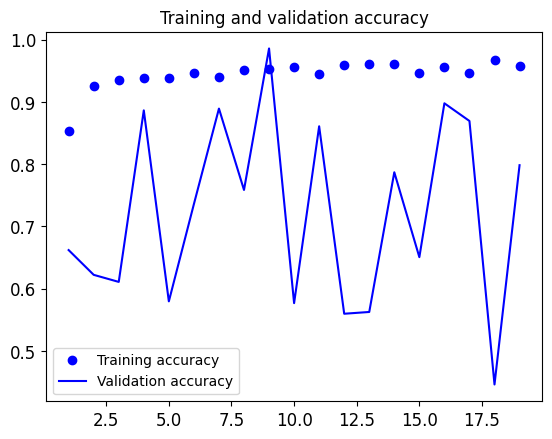

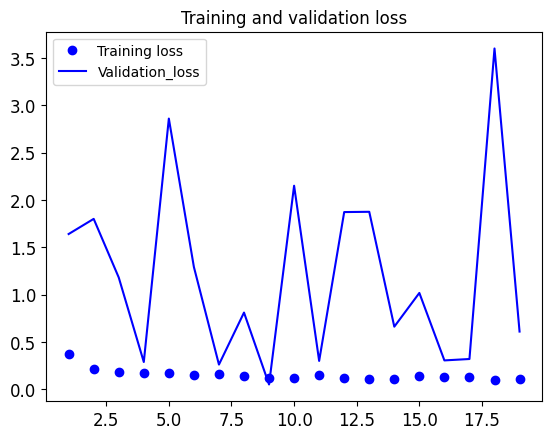

8/8 [==============================] - 1s 19ms/step - loss: 0.0333 - accuracy: 0.9921
테스트 정확도 : 99.206%
8/8 [==============================] - 1s 15ms/step


In [28]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 0.1

MODEL_SAVE_PATH = "/content/drive/My Drive/딥러닝/TermProject/rsp_Xception_change_hyperparameters.keras"

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
 
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과
start = time.time()
model.predict(test_set)
end = time.time()
model3_predict_time = end - start # prediction_time

rsp_results.loc["Xception_change_hp"] = (model3_test_acc, model3_test_loss, model3_predict_time) 

****

## 각 evaluation 결과

In [29]:
rsp_results

,test_acc,test_loss,pred_time
Xception_without_data_augmentation,1.0,0.000018,0.874107
Xception_with_data_augmentation,1.0,0.000001,0.904584
Xception_change_hp,0.992063,0.033273,0.909968


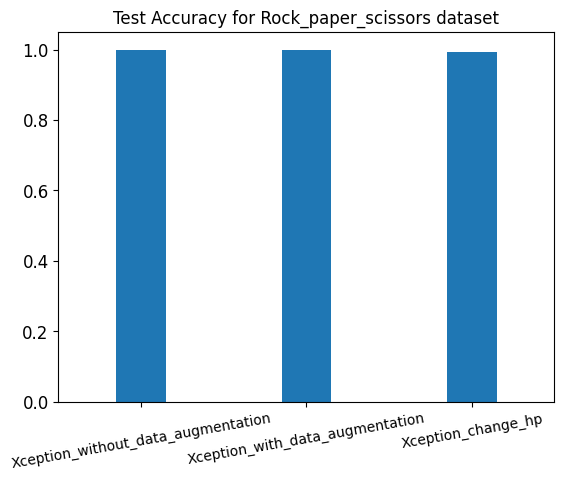

In [30]:
models = list(rsp_results.index)
test_accs = list(rsp_results["test_acc"])
plt.bar(range(len((models))), test_accs, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Accuracy for Rock_paper_scissors dataset')

ax = plt.subplot()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/rsp_test_accuracy.png')

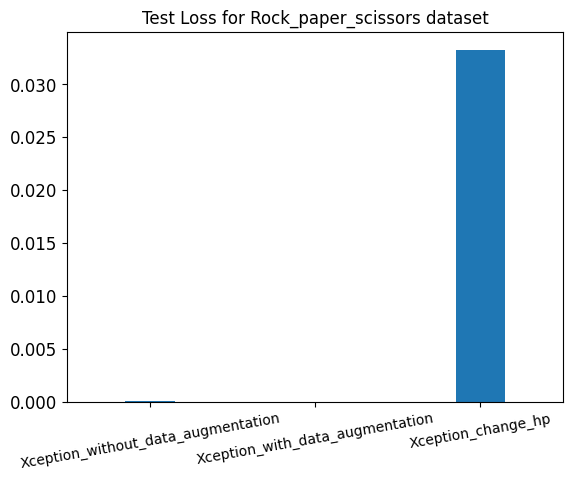

In [31]:
test_losss = list(rsp_results["test_loss"])
plt.bar(range(len((models))), test_losss, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Loss for Rock_paper_scissors dataset')

ax = plt.subplot()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/rsp_test_loss.png')

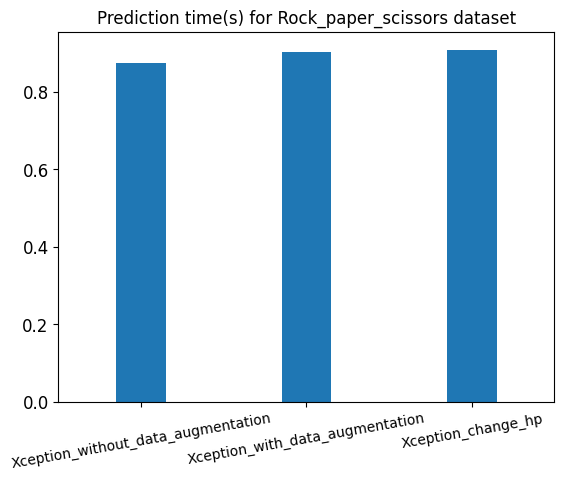

In [32]:
pred_times = list(rsp_results["pred_time"])
plt.bar(range(len((models))), pred_times, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Prediction time(s) for Rock_paper_scissors dataset')

ax = plt.subplot()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/rsp_prediction_time.png')

***

# 2. Eurosat

In [33]:
dataset, info = tfds.load("eurosat/rgb", as_supervised=True, with_info=True)
class_names = info.features["label"].names 
n_classes = info.features["label"].num_classes # 10
dataset_size = info.splits["train"].num_examples # 27000

test_set_raw, valid_set_raw, train_set_raw = tfds.load("eurosat/rgb", 
                                                       as_supervised=True, 
                                                       split=["train[:10%]","train[10%:25%]", "train[25%:]"])


def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label


batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

eurosat_results = pd.DataFrame(columns = ['test_acc', 'test_loss', 'pred_time'], index = ['Xception_without_data_augmentation', 'Xception_with_data_augmentation', 'Xception_change_hp'])

```label names``` = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']    

```num_classes``` = 10  
```
FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
```  
```
info.splits  
>>> {Split('train'): <SplitInfo num_examples=27000, num_shards=1>}
```

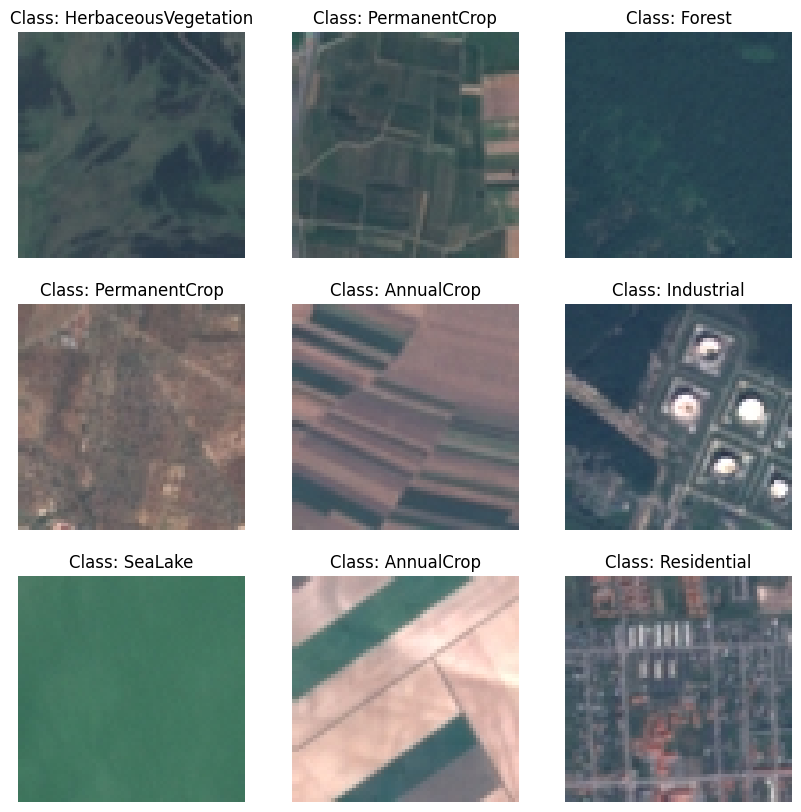

In [34]:
plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## (1) Data augmentation 미적용

Epoch 1/40
632/632 [==============================] - 63s 77ms/step - loss: 0.2375 - accuracy: 0.9269 - val_loss: 0.1001 - val_accuracy: 0.9690
Epoch 2/40
632/632 [==============================] - 50s 78ms/step - loss: 0.0633 - accuracy: 0.9779 - val_loss: 0.0574 - val_accuracy: 0.9821
Epoch 3/40
632/632 [==============================] - 47s 74ms/step - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.0605 - val_accuracy: 0.9807
Epoch 4/40
632/632 [==============================] - 49s 78ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0478 - val_accuracy: 0.9859
Epoch 5/40
632/632 [==============================] - 47s 74ms/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.0565 - val_accuracy: 0.9836
Epoch 6/40
632/632 [==============================] - 47s 74ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0820 - val_accuracy: 0.9787
Epoch 7/40
632/632 [==============================] - 47s 75ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0541 - val_accuracy:

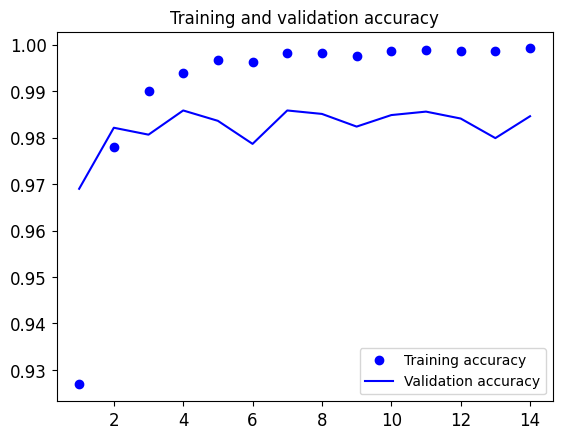

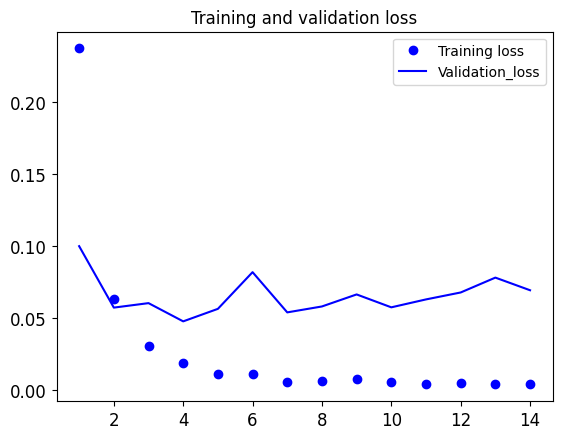

85/85 [==============================] - 2s 18ms/step - loss: 0.0602 - accuracy: 0.9837
테스트 정확도 : 98.370%
85/85 [==============================] - 2s 14ms/step


In [35]:
base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

MODEL_SAVE_PATH = "/content/drive/My Drive/딥러닝/TermProject/eurosat_Xception_without_data_augmentation.keras"
EPOCHS = 40 

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

model1_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model1_history, "eurosat_without_data_augmentation") # history graph
model1_test_loss, model1_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model1_predict_time = end - start # prediction_time

eurosat_results.loc["Xception_without_data_augmentation"] = (model1_test_acc, model1_test_loss, model1_predict_time) 

## (2) Data augmentation 적용

In [36]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


# 데이터 증강을 포함한 전처리 함수 정의
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential( # data augmentation
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- **augmentation 결과 확인**

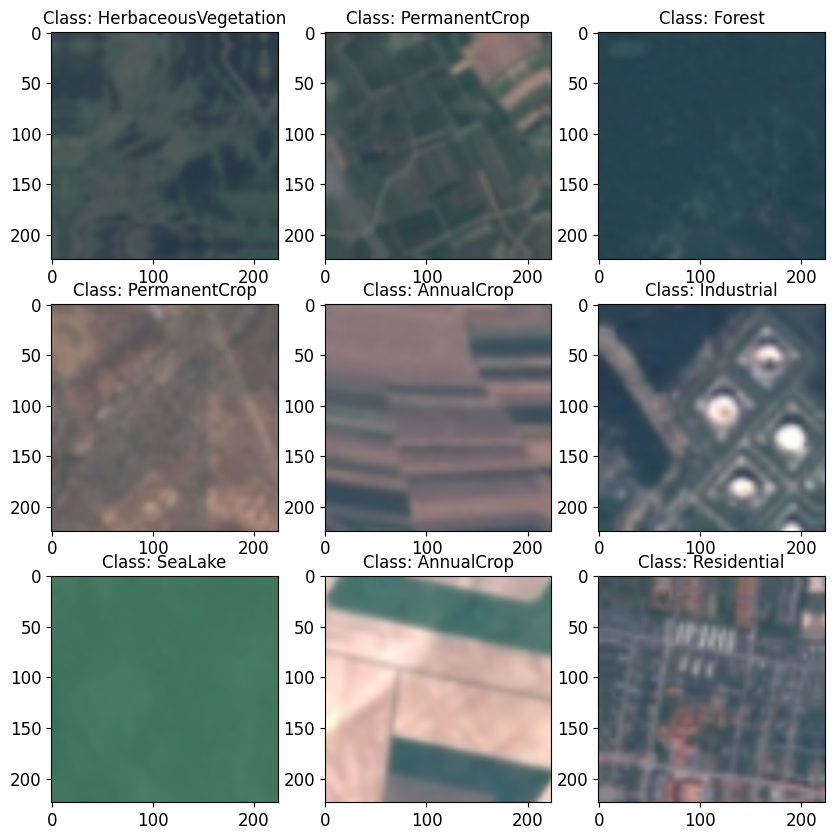

In [37]:
# augmentation 결과 확인 
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(augment_preprocess)).batch(batch_size).prefetch(1)
train_set = train_set_raw.map(augment_preprocess)

plt.figure(figsize = (10, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))

plt.show()

Epoch 1/40
632/632 [==============================] - 65s 80ms/step - loss: 0.3659 - accuracy: 0.8810 - val_loss: 3.8465 - val_accuracy: 0.3318
Epoch 2/40
632/632 [==============================] - 51s 81ms/step - loss: 0.1806 - accuracy: 0.9416 - val_loss: 1.9128 - val_accuracy: 0.5516
Epoch 3/40
632/632 [==============================] - 49s 77ms/step - loss: 0.1379 - accuracy: 0.9564 - val_loss: 3.2696 - val_accuracy: 0.4420
Epoch 4/40
632/632 [==============================] - 49s 77ms/step - loss: 0.1106 - accuracy: 0.9637 - val_loss: 5.0279 - val_accuracy: 0.3028
Epoch 5/40
632/632 [==============================] - 49s 77ms/step - loss: 0.0929 - accuracy: 0.9699 - val_loss: 2.6782 - val_accuracy: 0.6245
Epoch 6/40
632/632 [==============================] - 49s 77ms/step - loss: 0.0796 - accuracy: 0.9740 - val_loss: 4.1007 - val_accuracy: 0.5362
Epoch 7/40
632/632 [==============================] - 51s 81ms/step - loss: 0.0695 - accuracy: 0.9764 - val_loss: 1.8441 - val_accuracy:

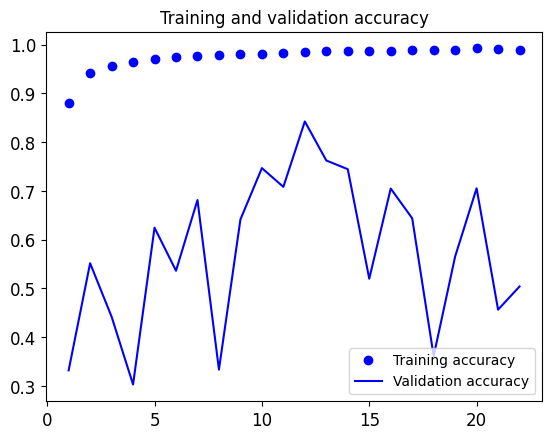

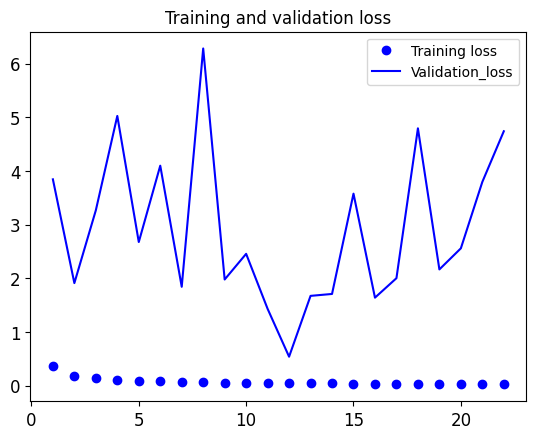

85/85 [==============================] - 4s 17ms/step - loss: 0.5506 - accuracy: 0.8337
테스트 정확도 : 83.370%
85/85 [==============================] - 2s 16ms/step


In [38]:
# 모델 적용을 위해 Input_size 수정한 ver
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    resized_image = tf.squeeze(resized_image)  # 차원 축소
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 데이터 증강을 포함한 전처리 함수 정의 (모델 적용을 위해 Input_size 수정한 ver)
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential(
    [
        layers.Conv2D(3, 3, input_shape=(224, 224, 3)),  # 입력 형태 설정
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

# inputs = keras.Input(shape=(None, None, 3)) 
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "/content/drive/My Drive/딥러닝/TermProject/eurosat_Xception_with_data_augmentation.keras"
EPOCHS = 40

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model2_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model2_history, "eurosat_with_data_augmentation") # history graph
model2_test_loss, model2_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model2_predict_time = end - start # prediction_time

eurosat_results.loc["Xception_with_data_augmentation"] = (model2_test_acc, model2_test_loss, model2_predict_time) 

# (3) 1-(2)에서 hyper parameter 변형
- 기존
  - epochs = 40
  - learning_rate = 0.01
  - batch_size = 32

#### 1. learning rate의 영향

Epoch 1/40
632/632 [==============================] - 46s 64ms/step - loss: 0.4089 - accuracy: 0.9047 - val_loss: 0.1619 - val_accuracy: 0.9546
Epoch 2/40
632/632 [==============================] - 40s 63ms/step - loss: 0.1574 - accuracy: 0.9539 - val_loss: 0.1607 - val_accuracy: 0.9573
Epoch 3/40
632/632 [==============================] - 40s 63ms/step - loss: 0.1353 - accuracy: 0.9602 - val_loss: 0.1134 - val_accuracy: 0.9707
Epoch 4/40
632/632 [==============================] - 39s 62ms/step - loss: 0.1302 - accuracy: 0.9615 - val_loss: 0.1613 - val_accuracy: 0.9568
Epoch 5/40
632/632 [==============================] - 40s 63ms/step - loss: 0.1096 - accuracy: 0.9667 - val_loss: 0.1108 - val_accuracy: 0.9685
Epoch 6/40
632/632 [==============================] - 39s 62ms/step - loss: 0.1055 - accuracy: 0.9683 - val_loss: 0.1489 - val_accuracy: 0.9571
Epoch 7/40
632/632 [==============================] - 40s 63ms/step - loss: 0.1016 - accuracy: 0.9693 - val_loss: 0.0977 - val_accuracy:

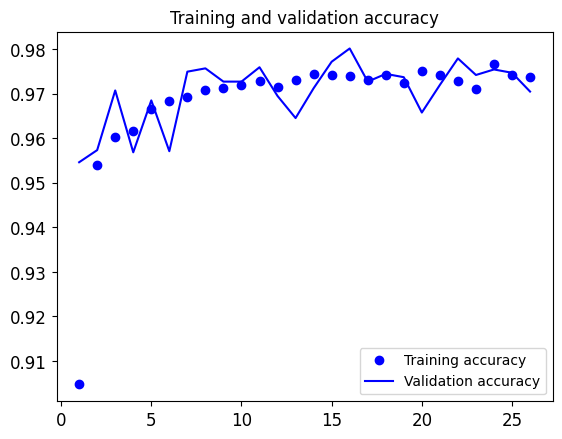

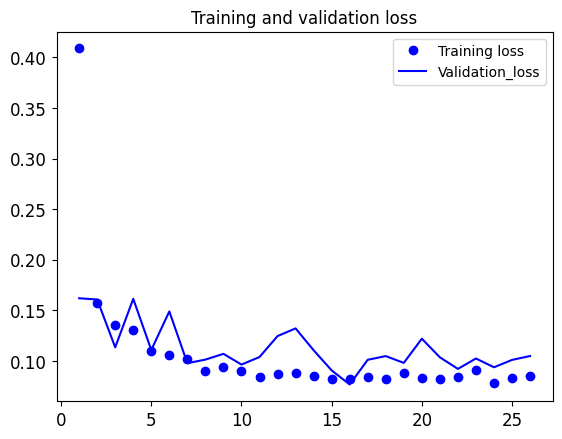

85/85 [==============================] - 2s 17ms/step - loss: 0.1122 - accuracy: 0.9744
테스트 정확도 : 97.444%


In [39]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 0.1

# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_change_hyperparameters.keras"

callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/40
632/632 [==============================] - 45s 64ms/step - loss: 2.2830 - accuracy: 0.1278 - val_loss: 2.2436 - val_accuracy: 0.1607
Epoch 2/40
632/632 [==============================] - 40s 63ms/step - loss: 2.2399 - accuracy: 0.2039 - val_loss: 2.1948 - val_accuracy: 0.3232
Epoch 3/40
632/632 [==============================] - 40s 63ms/step - loss: 2.1978 - accuracy: 0.2948 - val_loss: 2.1462 - val_accuracy: 0.4965
Epoch 4/40
632/632 [==============================] - 40s 63ms/step - loss: 2.1564 - accuracy: 0.3967 - val_loss: 2.0992 - val_accuracy: 0.6498
Epoch 5/40
632/632 [==============================] - 39s 62ms/step - loss: 2.1161 - accuracy: 0.4841 - val_loss: 2.0529 - val_accuracy: 0.7517
Epoch 6/40
632/632 [==============================] - 40s 63ms/step - loss: 2.0777 - accuracy: 0.5695 - val_loss: 2.0079 - val_accuracy: 0.8127
Epoch 7/40
632/632 [==============================] - 40s 63ms/step - loss: 2.0379 - accuracy: 0.6361 - val_loss: 1.9631 - val_accuracy:

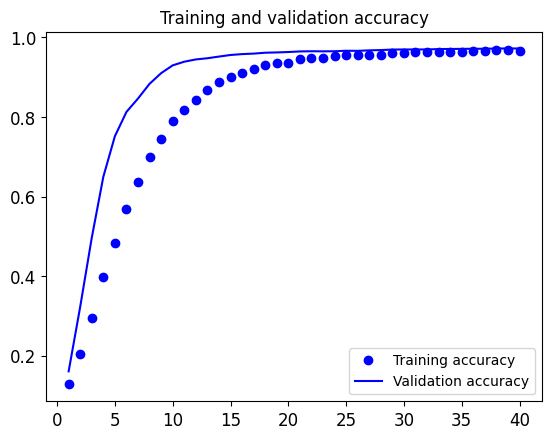

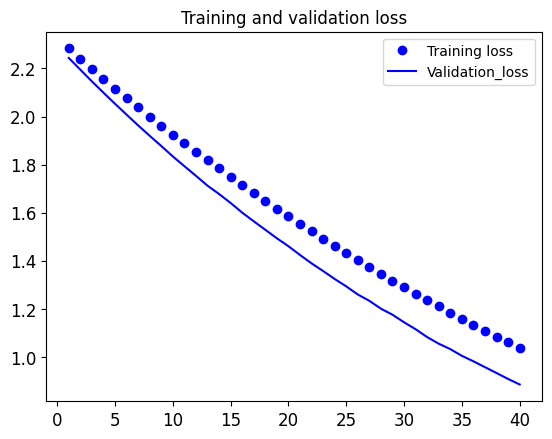

85/85 [==============================] - 2s 17ms/step - loss: 0.9115 - accuracy: 0.9693
테스트 정확도 : 96.926%


In [40]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 1e-5

# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_change_hyperparameters.keras"

callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

#### 2. epochs의 영향

Epoch 1/20
632/632 [==============================] - 45s 64ms/step - loss: 0.1112 - accuracy: 0.9684 - val_loss: 0.1039 - val_accuracy: 0.9722
Epoch 2/20
632/632 [==============================] - 40s 63ms/step - loss: 0.0910 - accuracy: 0.9716 - val_loss: 0.1038 - val_accuracy: 0.9750
Epoch 3/20
632/632 [==============================] - 39s 62ms/step - loss: 0.0890 - accuracy: 0.9722 - val_loss: 0.1996 - val_accuracy: 0.9511
Epoch 4/20
632/632 [==============================] - 39s 62ms/step - loss: 0.0839 - accuracy: 0.9740 - val_loss: 0.1183 - val_accuracy: 0.9673
Epoch 5/20
632/632 [==============================] - 39s 62ms/step - loss: 0.0771 - accuracy: 0.9764 - val_loss: 0.1357 - val_accuracy: 0.9640
Epoch 6/20
632/632 [==============================] - 39s 62ms/step - loss: 0.0756 - accuracy: 0.9767 - val_loss: 0.1103 - val_accuracy: 0.9732
Epoch 7/20
632/632 [==============================] - 39s 62ms/step - loss: 0.0793 - accuracy: 0.9763 - val_loss: 0.1003 - val_accuracy:

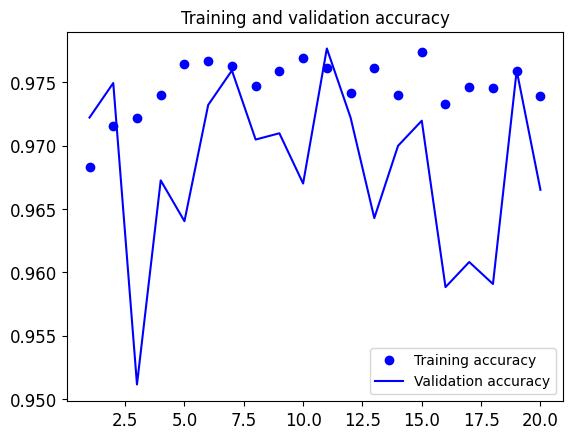

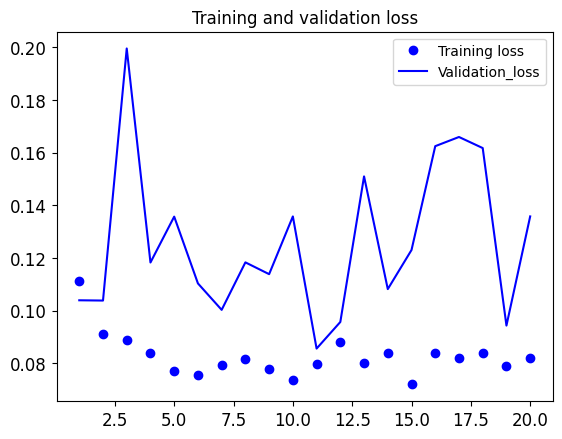

85/85 [==============================] - 2s 17ms/step - loss: 0.1205 - accuracy: 0.9678
테스트 정확도 : 96.778%


In [41]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 20
lr = 0.1

# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_change_hyperparameters.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/100
632/632 [==============================] - 45s 64ms/step - loss: 0.1210 - accuracy: 0.9659 - val_loss: 0.1240 - val_accuracy: 0.9740
Epoch 2/100
632/632 [==============================] - 40s 63ms/step - loss: 0.0835 - accuracy: 0.9749 - val_loss: 0.1230 - val_accuracy: 0.9692
Epoch 3/100
632/632 [==============================] - 40s 63ms/step - loss: 0.0850 - accuracy: 0.9743 - val_loss: 0.1409 - val_accuracy: 0.9640
Epoch 4/100
632/632 [==============================] - 40s 63ms/step - loss: 0.0823 - accuracy: 0.9746 - val_loss: 0.1016 - val_accuracy: 0.9720
Epoch 5/100
632/632 [==============================] - 39s 62ms/step - loss: 0.0877 - accuracy: 0.9732 - val_loss: 0.1085 - val_accuracy: 0.9732
Epoch 6/100
632/632 [==============================] - 40s 63ms/step - loss: 0.0841 - accuracy: 0.9739 - val_loss: 0.1402 - val_accuracy: 0.9648
Epoch 7/100
632/632 [==============================] - 39s 63ms/step - loss: 0.0773 - accuracy: 0.9757 - val_loss: 0.1263 - val_ac

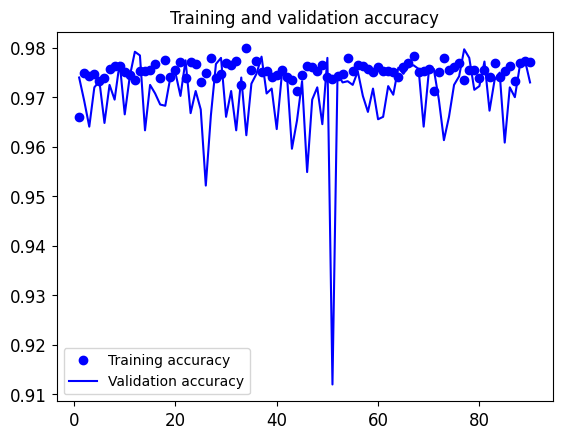

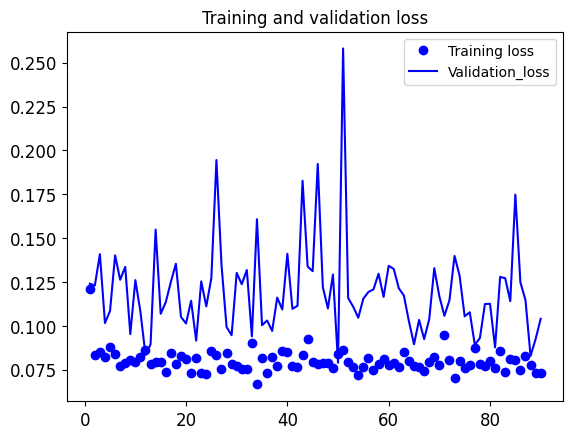

85/85 [==============================] - 2s 17ms/step - loss: 0.0953 - accuracy: 0.9737
테스트 정확도 : 97.370%


In [42]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 100
lr = 0.1

# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_change_hyperparameters.keras"

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 40) # Early_Stopping
callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/40
632/632 [==============================] - 45s 64ms/step - loss: 0.1146 - accuracy: 0.9687 - val_loss: 0.1268 - val_accuracy: 0.9603
Epoch 2/40
632/632 [==============================] - 41s 65ms/step - loss: 0.0909 - accuracy: 0.9719 - val_loss: 0.1152 - val_accuracy: 0.9690
Epoch 3/40
632/632 [==============================] - 41s 65ms/step - loss: 0.0856 - accuracy: 0.9729 - val_loss: 0.0859 - val_accuracy: 0.9784
Epoch 4/40
632/632 [==============================] - 39s 62ms/step - loss: 0.0773 - accuracy: 0.9765 - val_loss: 0.1444 - val_accuracy: 0.9611
Epoch 5/40
632/632 [==============================] - 39s 62ms/step - loss: 0.0899 - accuracy: 0.9717 - val_loss: 0.0889 - val_accuracy: 0.9789
Epoch 6/40
632/632 [==============================] - 39s 62ms/step - loss: 0.0784 - accuracy: 0.9764 - val_loss: 0.0990 - val_accuracy: 0.9762
Epoch 7/40
632/632 [==============================] - 39s 62ms/step - loss: 0.0798 - accuracy: 0.9750 - val_loss: 0.1077 - val_accuracy:

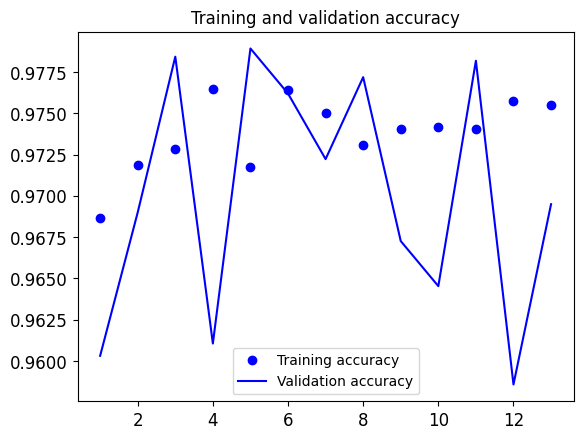

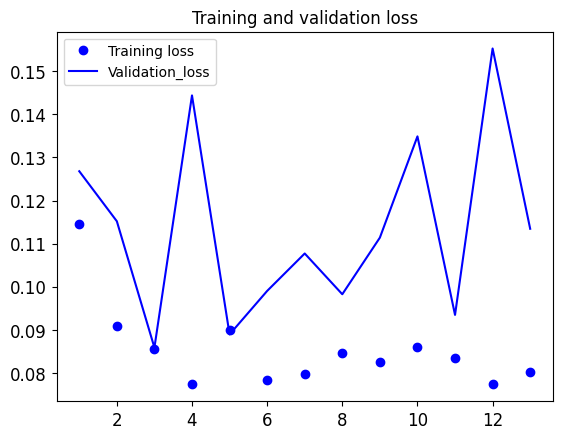

85/85 [==============================] - 2s 17ms/step - loss: 0.1102 - accuracy: 0.9707
테스트 정확도 : 97.074%
85/85 [==============================] - 2s 15ms/step


In [43]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 0.1

MODEL_SAVE_PATH = "/content/drive/My Drive/딥러닝/TermProject/eurosat_Xception_change_hyperparameters.keras"

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
 
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과
start = time.time()
model.predict(test_set)
end = time.time()
model3_predict_time = end - start # prediction_time

eurosat_results.loc["Xception_change_hp"] = (model3_test_acc, model3_test_loss, model3_predict_time) 

***

# 각 evaluation 결과 확인

In [45]:
eurosat_results

,test_acc,test_loss,pred_time
Xception_without_data_augmentation,0.983704,0.060203,1.99886
Xception_with_data_augmentation,0.833704,0.550581,2.392462
Xception_change_hp,0.970741,0.110217,2.14073


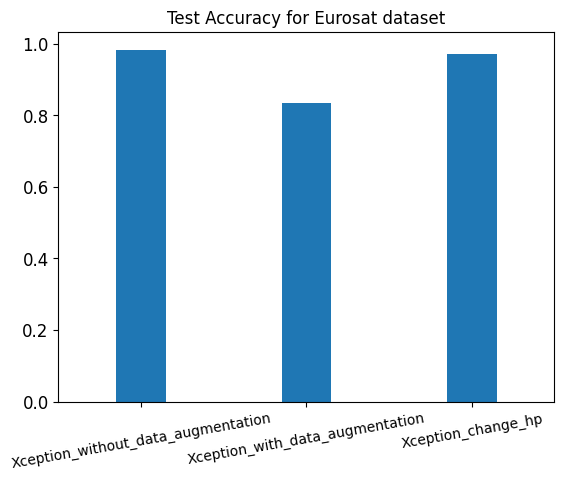

In [46]:
models = list(eurosat_results.index)
test_accs = list(eurosat_results["test_acc"])
plt.bar(range(len((models))), test_accs, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Accuracy for Eurosat dataset')

ax = plt.subplot()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/eurosat_test_accuracy.png')

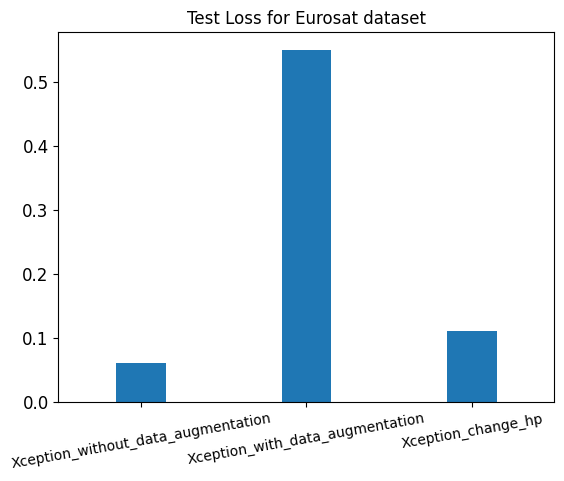

In [47]:
test_losss = list(eurosat_results["test_loss"])
plt.bar(range(len((models))), test_losss, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Loss for Eurosat dataset')

ax = plt.subplot()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/eurosat_test_loss.png')

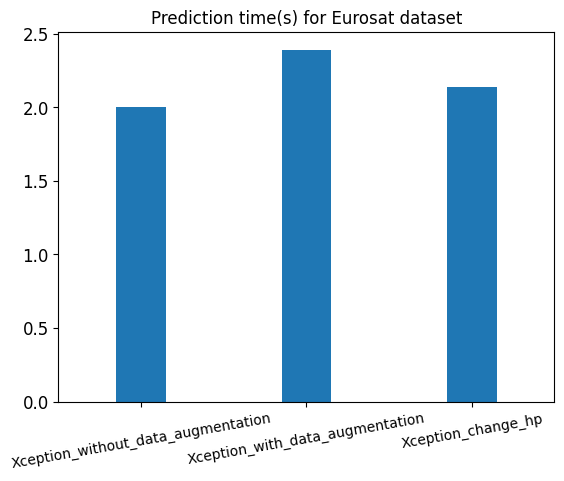

In [48]:
pred_times = list(eurosat_results["pred_time"])
plt.bar(range(len((models))), pred_times, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Prediction time(s) for Eurosat dataset')

ax = plt.subplot()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

plt.savefig(f'/content/drive/My Drive/딥러닝/TermProject/eurosat_prediction_time.png')